In [245]:
import math
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
from google.colab import files
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from scipy.stats import entropy
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score 
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
import random
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from joblib import dump, load
import os
import seaborn as sns
import graphviz
from sklearn.manifold import TSNE


Read the data from the "Sleep_Efficiency after EDA.csv" file


In [246]:
sleepData = pd.read_csv("/content/sample_data/Sleep Efficiency after EDA.csv")

Drop duplicates if any

In [247]:
sleepData.drop_duplicates(inplace=True)
sleepData=sleepData.drop("ID", axis=1)

np.random.seed(42)

Data cleaning

In [248]:
# Function to clean the time part from the "Bedtime" and "Wakeup time" columns
def cleanSleepTime(columnName):
    sleepData[columnName] = pd.to_datetime(sleepData[columnName], format='%Y-%m-%d %H:%M:%S').dt.time.apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)

    # sleepData[columnName] = sleep_time  # Update the column in the DataFrame

# Function to fill missing numeric values with the average of non-missing values
def fillNumericAvg(data):
    if not isinstance(data, pd.DataFrame):  # Check if input is a DataFrame
        raise TypeError("Input data must be a pandas DataFrame")
    numeric_cols = data.select_dtypes(include=np.number).columns.tolist()  # Get numeric columns
    data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())  # Fill missing values with means

# Function to fill missing values in a column with the mode
def fillColumnMode(data, column):
    col_mode = data[column].mode()[0]  # Compute the mode of the column (ignoring missing values)
    data[column].fillna(col_mode, inplace=True)  # Fill missing values with the mode

def preprocessData(data):
    # Clean the "Bedtime" and "Wakeup time" columns
    cleanSleepTime("Bedtime")
    cleanSleepTime("Wakeup time")

    # Fill missing numeric values in the DataFrame with the average
    fillNumericAvg(data)
    
    # Fill missing values in the "Smoking status" column with the mode
    fillColumnMode(data, "Smoking status")
    
    # Replace "Yes" and "No" values in the "Smoking status" column with 1 and 0, respectively
    data["Smoking status"] = data["Smoking status"].replace({"Yes": 1, "No": 0})

preprocessData(sleepData)

# sleepData.to_csv('Sleep efficiency after cleaning.csv', index=False,encoding='utf-8-sig')
# files.download('Sleep efficiency after cleaning.csv')

K-means

cluster  Gender
0        Female    116
         Male      125
1        Female    108
         Male      103
dtype: int64


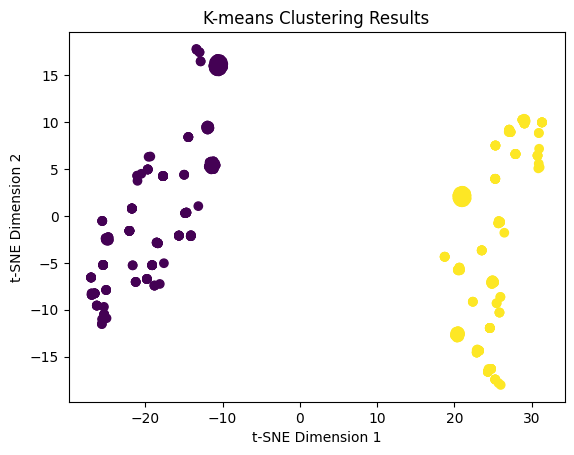

In [249]:
def K_means():
    X_Kmeans = sleepData.drop('Gender', axis=1)
    k = 2  # Number of clusters
    # Instantiate the KMeans class
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    # Fit the k-means model to the data
    kmeans.fit(X_Kmeans)
    # Get the predicted cluster labels
    cluster_labels = kmeans.labels_

    # Add the cluster labels to the original dataset
    sleepData['cluster'] = cluster_labels

    # Analyze the distribution of gender within each cluster
    gender_distribution = sleepData.groupby(['cluster', 'Gender']).size()
    print(gender_distribution)

    # Create a scatter plot of the data points with color-coded clusters

    # Perform dimensionality reduction using t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_Kmeans)

    # Create a scatter plot of the data points with color-coded clusters
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title('K-means Clustering Results')
    plt.show()

K_means()

Calculation of entropy on the whole column

In [250]:
def calculate_entropy(data):
    entropy_values = {}
    num_samples = len(data)

    for column in data.columns:
        values, counts = np.unique(data[column].dropna(), return_counts=True)
        probabilities = counts / num_samples
        entropy = -np.sum(probabilities * np.log2(probabilities))
        entropy_values[column] = entropy

    return entropy_values

entropy_values = calculate_entropy(sleepData)
for column, entropy in entropy_values.items():
    print(f"Entropy of column '{column}': {entropy}")

Entropy of column 'Age': 5.503109912730437
Entropy of column 'Gender': 0.9999435071707974
Entropy of column 'Bedtime': 3.3849444789754433
Entropy of column 'Wakeup time': 3.8911427992676173
Entropy of column 'Sleep duration': 2.4954651159529644
Entropy of column 'Sleep efficiency': 5.341295480237125
Entropy of column 'REM sleep percentage': 3.2710844611484546
Entropy of column 'Deep sleep percentage': 4.1973598479298655
Entropy of column 'Light sleep percentage': 4.153274012116889
Entropy of column 'Awakenings': 2.370462207714785
Entropy of column 'Caffeine consumption': 1.949680225532007
Entropy of column 'Alcohol consumption': 2.1166345381684173
Entropy of column 'Smoking status': 0.9254945678029334
Entropy of column 'Exercise frequency': 2.363191154602921
Entropy of column 'cluster': 0.9968199826615665


*Features* selection-
The code below corresponds to the data after selecting columns and analyzing all the data without selecting columns.
To run the normalisations and all the models without selecting columns, put the code that appears below in the documents

In [251]:
# selectedColumns=['Smoking status', 'Caffeine consumption', 'Alcohol consumption','Exercise frequency', 'Sleep duration', 'Awakenings','Gender']
# sleepData=sleepData.loc[:,selectedColumns]

Split the data into training and testing sets


In [252]:
X = sleepData.drop("Gender", axis=1)
y = sleepData["Gender"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Apply different normalization techniques to the data





In [253]:
def applyNormalization(data, scaler):
    numeric_cols = data.select_dtypes(include=np.number).columns.tolist()
    data_normalized = data.copy()
    data_normalized[numeric_cols] = scaler.fit_transform(data_normalized[numeric_cols])
    return data_normalized

Apply Decimal scaling normalization techniq to the data

In [254]:
def applyDecimalScaling(data):
    normalized_data = data.copy()
    for column in normalized_data.columns:
        max_value = normalized_data[column].max()
        num_digits = len(str(int(max_value)))
        normalized_data[column] = normalized_data[column] / (10 ** num_digits)
    return normalized_data

To smooth data by Bin boundaries, Bin means depth

In [255]:
def applyBinBoundaries(data, column, num_bins):
    normalized_data = data.copy()
    
    # Sort the data based on the specified column
    sorted_data = normalized_data.sort_values(by=column)

    # Assign bin boundaries based on equal intervals
    bin_boundaries = pd.qcut(sorted_data[column], num_bins, labels=False, duplicates="drop")
    normalized_data[column] = bin_boundaries
    
    # Assign values to the closest boundary within each bin
    for bin_label in range(num_bins):
        bin_indices = np.where(bin_boundaries == bin_label)[0]
        min_value = sorted_data[column].iloc[bin_indices].min()
        max_value = sorted_data[column].iloc[bin_indices].max()
        
        # Assign values to the closest boundary within the bin
        normalized_data.loc[bin_indices, column] = sorted_data.loc[bin_indices, column].apply(
            lambda x: min_value if abs(x - min_value) < abs(x - max_value) else max_value
        )
    return normalized_data

def applyBinMeans_depth(data, column, num_bins):
    normalized_data = data.copy()

    # Sort the data based on the specified column
    sorted_data = normalized_data.sort_values(by=column)

    # Assign bin boundaries based on equal intervals
    bin_boundaries = pd.qcut(sorted_data[column], num_bins, labels=False, duplicates="drop")
    normalized_data[column] = bin_boundaries

    # Assign values to the average within each bin
    for bin_label in range(num_bins):
        bin_indices = np.where(bin_boundaries == bin_label)[0]
        bin_values = sorted_data[column].iloc[bin_indices]
        avg_value = np.mean(bin_values)

        normalized_data.loc[bin_indices, column] = avg_value

    return normalized_data


Train and evaluate a classifier 
and printing evaluation metrics

In [256]:
def trainAndEvaluateClassifier(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)

    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    confusion_mat = confusion_matrix(y_test, y_pred)
    
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print("Confusion Matrix:")
    print(confusion_mat)
    print("")
    
    return classifier


Train and evaluate the Naive Bayes classifier
and printing evaluation metrics

In [257]:
def train_and_evaluate_naive_bayes(X_train, y_train, X_test, y_test):
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    y_pred = gnb.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    confusion_mat = confusion_matrix(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print("Confusion Matrix:")
    print(confusion_mat)
    print("")
    
    return accuracy, precision, recall, f1, confusion_mat

Define the normalization techniques and corresponding scalers


In [258]:
normalization_techniques = [
    ("Min-Max Scaling", MinMaxScaler()),
    ("Z-Score Scaling", StandardScaler()),
    ("Decimal Scaling", applyDecimalScaling),
    ("Unit Vector Normalization", Normalizer()),
    ("Bin boundaries",applyBinBoundaries)
]

Train and evaluate classifiers for each normalization technique (all the data)

In [259]:
for technique_name, scaler in normalization_techniques:
  # Apply the normalization technique
    if technique_name == "Decimal Scaling":
        normalized_data = scaler(X)

    elif technique_name == "Bin boundaries":
      continue

    else:
        normalized_data = applyNormalization(X, scaler)

    # Split the normalized data into training and testing sets
    X_train_normalized, X_test_normalized, y_train_normalized, y_test_normalized = train_test_split(normalized_data, y, test_size=0.2, random_state=42)
    
    print(f"{technique_name} - Decision Tree:")
    decision_tree = DecisionTreeClassifier()
    trainAndEvaluateClassifier(decision_tree, X_train_normalized, y_train_normalized, X_test_normalized, y_test_normalized)
    
    print(f"{technique_name} - Random Forest:")
    rf = RandomForestClassifier()
    trainAndEvaluateClassifier(rf, X_train_normalized, y_train_normalized, X_test_normalized, y_test_normalized)

    print(f"{technique_name} - Naive Bayes:")
    train_and_evaluate_naive_bayes(X_train_normalized, y_train_normalized, X_test_normalized, y_test_normalized)

    print(f"{technique_name} - KNN (k = 5):")
    knn = KNeighborsClassifier()
    trainAndEvaluateClassifier(knn, X_train_normalized, y_train_normalized, X_test_normalized, y_test_normalized)

    print(f"{technique_name} - KNN(k = 3):")
    knn = KNeighborsClassifier(n_neighbors = 3)
    trainAndEvaluateClassifier(knn, X_train_normalized, y_train_normalized, X_test_normalized, y_test_normalized)
    
    print(f"{technique_name} - KNN(k = 7):")
    knn = KNeighborsClassifier(n_neighbors = 7)
    trainAndEvaluateClassifier(knn, X_train_normalized, y_train_normalized, X_test_normalized, y_test_normalized)

    print("---") 


Min-Max Scaling - Decision Tree:
Accuracy: 0.8571428571428571
Precision: 0.8568591289544616
Recall: 0.8571428571428571
F1-Score: 0.8568954854669142
Confusion Matrix:
[[32  7]
 [ 6 46]]

Min-Max Scaling - Random Forest:
Accuracy: 0.945054945054945
Precision: 0.9465367965367965
Recall: 0.945054945054945
F1-Score: 0.9447263017356474
Confusion Matrix:
[[35  4]
 [ 1 51]]

Min-Max Scaling - Naive Bayes:
Accuracy: 0.8241758241758241
Precision: 0.8236808236808237
Recall: 0.8241758241758241
F1-Score: 0.8235210668179884
Confusion Matrix:
[[30  9]
 [ 7 45]]

Min-Max Scaling - KNN (k = 5):
Accuracy: 0.8681318681318682
Precision: 0.8693877551020408
Recall: 0.8681318681318682
F1-Score: 0.867009867009867
Confusion Matrix:
[[31  8]
 [ 4 48]]

Min-Max Scaling - KNN(k = 3):
Accuracy: 0.8021978021978022
Precision: 0.8070660522273425
Recall: 0.8021978021978022
F1-Score: 0.7979591836734694
Confusion Matrix:
[[26 13]
 [ 5 47]]

Min-Max Scaling - KNN(k = 7):
Accuracy: 0.8571428571428571
Precision: 0.85935426

function randomly selects a subset of columns from the input data and applies a randomly chosen normalization technique to each selected column.

The function iterates through the selected columns, randomly selects a normalization technique, and applies it to the corresponding column.

In [260]:
def randomNormalization(data):
    normalized_data = data.copy()
    columns = normalized_data.columns.tolist()
    
    # Randomly select columns to normalize
    num_columns_to_normalize = random.randint(1, len(columns) - 1)  # Choose a random number of columns to normalize
    
    if num_columns_to_normalize > 0:
        columns_to_normalize = random.sample(columns, num_columns_to_normalize)
        
        for column in columns_to_normalize:

            # Randomly select a normalization technique for each column
            normalization_techniques = [
                ("Min-Max Scaling", MinMaxScaler()),
                ("Z-Score Scaling", StandardScaler()),
                ("Decimal Scaling", applyDecimalScaling),
                ("Unit Vector Normalization", Normalizer()),
                ("Bin Boundaries", applyBinBoundaries),
                ("Bin Means depth", applyBinMeans_depth),
                ("Bin Boundaries",applyBinBoundaries)
            ] 
            
            technique_name, scaler = random.choice(normalization_techniques)
            
            # Apply the selected normalization technique
            if technique_name == "Decimal Scaling":
                max_value = normalized_data[column].max()
                num_digits = len(str(int(max_value)))
                normalized_data[column] = normalized_data[column] / (10 ** num_digits)

            elif technique_name == "Unit Vector Normalization":
                normalized_data[column] = scaler.fit_transform(normalized_data[column].values.reshape(-1, 1))
                normalized_data[column] = normalized_data[column]
            elif technique_name == "Bin Boundaries" or technique_name == "Bin Means depth":
                num_bins = random.randint(2, 10)  # Choose a random number of bins
                normalized_data = scaler(normalized_data, column, num_bins)

            else:
                normalized_data[column] = scaler.fit_transform(normalized_data[column].values.reshape(-1, 1))
            
            print(f"{technique_name} applied to column: {column}")
    
    return normalized_data


Train and evaluate classifiers for each normalization technique (Random columns with random normalization on each selected column)

In [261]:
for _ in range(0,4):

    normalized_data = randomNormalization(X)
    
    #normalized_data = applyNormalization(normalized_data, scaler)

    # Split the normalized data into training and testing sets
    X_train_normalized, X_test_normalized, y_train_normalized, y_test_normalized = train_test_split(
        normalized_data, y, test_size=0.2, random_state=42)

    print("Decision Tree:")
    decision_tree = DecisionTreeClassifier()
    trainAndEvaluateClassifier(decision_tree, X_train_normalized, y_train_normalized, X_test_normalized, y_test_normalized)
    
    print("Random Forest:")
    rf = RandomForestClassifier()
    trainAndEvaluateClassifier(rf, X_train_normalized, y_train_normalized, X_test_normalized, y_test_normalized)
    
    
    print("Naive Bayes:")
    train_and_evaluate_naive_bayes(X_train_normalized, y_train_normalized, X_test_normalized, y_test_normalized)
    print("KNN (k = 5):")
    knn = KNeighborsClassifier()
    trainAndEvaluateClassifier(knn, X_train_normalized, y_train_normalized, X_test_normalized, y_test_normalized)

    
    print("KNN (k = 3):")
    knn = KNeighborsClassifier(n_neighbors=3)
    trainAndEvaluateClassifier(knn, X_train_normalized, y_train_normalized, X_test_normalized, y_test_normalized)


    print("KNN (k = 7):")
    knn = KNeighborsClassifier()
    trainAndEvaluateClassifier(knn, X_train_normalized, y_train_normalized, X_test_normalized, y_test_normalized)

    print("---")




Unit Vector Normalization applied to column: Bedtime
Min-Max Scaling applied to column: Caffeine consumption
Z-Score Scaling applied to column: Awakenings
Decision Tree:
Accuracy: 0.8681318681318682
Precision: 0.868010868010868
Recall: 0.8681318681318682
F1-Score: 0.8676408001134913
Confusion Matrix:
[[32  7]
 [ 5 47]]

Random Forest:
Accuracy: 0.945054945054945
Precision: 0.9465367965367965
Recall: 0.945054945054945
F1-Score: 0.9447263017356474
Confusion Matrix:
[[35  4]
 [ 1 51]]

Naive Bayes:
Accuracy: 0.7692307692307693
Precision: 0.7700980392156863
Recall: 0.7692307692307693
F1-Score: 0.7695710949981565
Confusion Matrix:
[[29 10]
 [11 41]]

KNN (k = 5):
Accuracy: 0.6153846153846154
Precision: 0.6410256410256411
Recall: 0.6153846153846154
F1-Score: 0.6153846153846153
Confusion Matrix:
[[28 11]
 [24 28]]

KNN (k = 3):
Accuracy: 0.6813186813186813
Precision: 0.7172887172887173
Recall: 0.6813186813186813
F1-Score: 0.6801636203593434
Confusion Matrix:
[[32  7]
 [22 30]]

KNN (k = 7):
A

The selected model, with the selected normals on part of the column.
The function executes the final result with the best results!
The function will download the data with the best preprocessing and also the best model.
And at the end, graphs describing the results will be displayed on the screen

Accuracy: 0.978021978021978
Precision: 0.9788359788359788
Recall: 0.978021978021978
F1-Score: 0.9779401333522485
Confusion Matrix:
[[37  2]
 [ 0 52]]



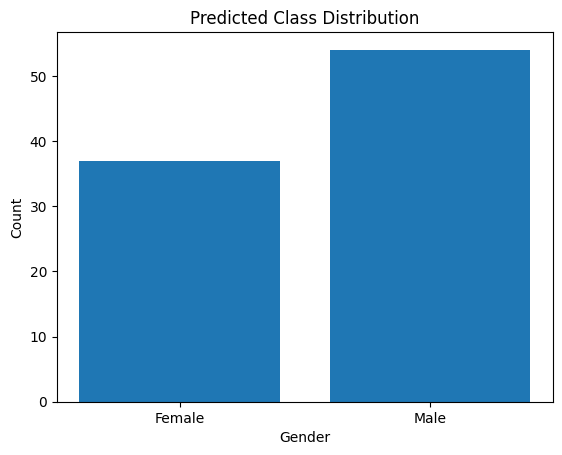

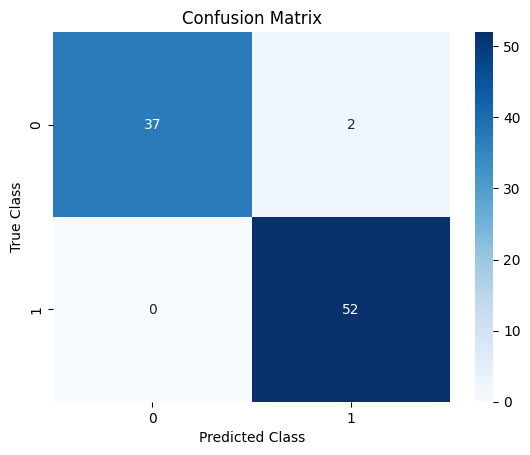

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [262]:
#Applies data preprocessing techniques and trains a Random Forest classifier to improve the model's performance. 

def ModelImprovement(sleepData):

  scaler=MinMaxScaler()
  # Apply MinMax scaling to 'Exercise frequency' column
  sleepData['Exercise frequency']=scaler.fit_transform(sleepData['Exercise frequency'].values.reshape(-1, 1))

  # Apply binning boundaries to 'Light sleep percentage' column
  sleepData=applyBinBoundaries(sleepData,'Light sleep percentage', 4)

  scaler=StandardScaler()
  # Apply Standard scaling to 'Alcohol consumption' column
  sleepData['Alcohol consumption']=scaler.fit_transform(sleepData['Alcohol consumption'].values.reshape(-1, 1))

  # Apply binning boundaries to 'Deep sleep percentage' column
  sleepData=applyBinBoundaries(sleepData, 'Deep sleep percentage', 4)

  # Apply binning boundaries to 'Smoking status' column
  sleepData=applyBinBoundaries(sleepData,'Smoking status', 4)

  # Apply binning boundaries to 'Wakeup time' column
  sleepData=applyBinBoundaries(sleepData, 'Wakeup time', 4)

  # Initialize a Random Forest classifier
  rf = RandomForestClassifier()

  # Split the data into training and testing sets
  X_train_normalized, X_test_normalized, y_train_normalized, y_test_normalized = train_test_split(
        sleepData, y, test_size=0.2, random_state=42)
  
  # Train and evaluate the classifier
  rf = trainAndEvaluateClassifier(rf, X_train_normalized, y_train_normalized, X_test_normalized, y_test_normalized) 
  
  # Generate the summarizing graphs
  predictions = rf.predict(X_test_normalized)
  class_counts = dict(zip(*np.unique(predictions, return_counts=True)))

  # Visualize the predicted class distribution using a bar chart
  plt.bar(class_counts.keys(), class_counts.values())
  plt.xlabel('Gender')
  plt.ylabel('Count')
  plt.title('Predicted Class Distribution')
  plt.show()

  # Calculate and visualize the confusion matrix
  conf_matrix = confusion_matrix(y_test_normalized, predictions)
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
  plt.xlabel("Predicted Class")
  plt.ylabel("True Class")
  plt.title("Confusion Matrix")
  plt.show()

  #Downloading the model and the good preprocessing 
  dump(rf, 'bestModel.pkl')
  normalized_data.to_csv('Sleep efficiency_clean.csv', index=False, encoding='utf-8-sig')
  files.download('Sleep efficiency_clean.csv')

dataImprovment=X.copy()
#function call
ModelImprovement(dataImprovment)